# A Multiclass Support Vector Machine for Image Classification

### Solution to Assignment 1 [CS 231, Neural Nets for Visual Recognition](http://cs231n.stanford.edu/syllabus.html) ( part 1 ) 

#### This notebook deals with the `SVM` part of the assignment; the two-layer neural network is implemented in a separate notebook.

Data set used: [`CIFAR-10` data set ](https://www.cs.toronto.edu/~kriz/cifar.html). 

+ `CIFAR-10` has 10 labels
+ 50 000 tiny training images (color images, 32 X 32 X 3 pixels each)
+ 10 000 test images


+ The assignment instructions are found [here](http://cs231n.github.io/assignments2016/assignment1/) 
+ The files needed to complete the entire assignment ( a zip file ) [can be downloaded from here](http://vision.stanford.edu/teaching/cs231n/winter1516_assignment1.zip) 
+ To reproduce the results found in this notebook, first download and unzip the assignment files. A directory called `assignment1` will be created after the files have been unzipped. Then download this notebook and save it in the `assignment1` directory
+ Make sure to download the `CIFAR-10` data as well. This can be done by simply running the `./get_datasets.sh` script from the `assignment1/cs231n/datasets` directory ( these instructions are also found on the [assignment instructions page](http://cs231n.github.io/assignments2016/assignment1/) )
+ Now simply run the code in this notebook as usual

The lecture [notes on linear classification can be found here](http://cs231n.github.io/linear-classify/). This solution is based on the material contained in those notes.

## This notebook shows how to:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check the implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD** (stochastic gradient descent)
- **visualize** the final learned weights


## Load, View and Preprocess the `CIFAR-10` Data

### Preprocessing, part 1 of 2

Here we just load the data and look at a few images in each of the 10 classes. Each column in the picture below represents a class. Images within the columns are examples from the classs represented by the columns.

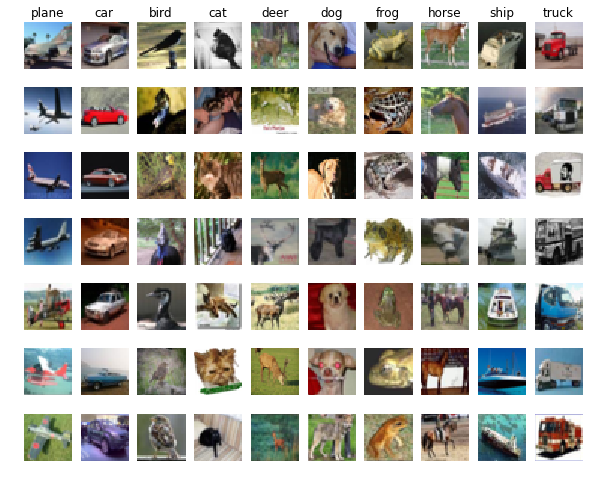

In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Preprocessing, part 2 of 2

Here we prepare data for machine learning. We do two things: 

1. We split the data into train, validation and test sets 

2. We perform normalization of our input features (i.e. we normalize the images. Note on terminology: each intensity value of an input image is called a `feature` here. Each image in `CIFAR-10` has 32 X 32 pixels X 3 color chanels = 3072 intensity values.)

For part 2, we center the data by subtracting the mean from every feature. This means that we _first_ compute the mean of every feature in the training set. This vector of means, which is 3072 long since we have that many features, can be reshaped into an image and refered to as the _mean image_  (what the mean image looks like is shown below). We _next_ subtract the mean image from every training image. As a result, our training data now consists of images whose pixel intensities range from about -127 to about +127. We then scale each input feature so that its values range from -1 to +1. The reason for doing this will become apparent when we understand the dynamics of the gradient descent algorithm. 

In [2]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

#print 'Train data shape: ', X_train.shape
#print 'Train labels shape: ', y_train.shape
#print 'Validation data shape: ', X_val.shape
#print 'Validation labels shape: ', y_val.shape
#print 'Test data shape: ', X_test.shape
#print 'Test labels shape: ', y_test.shape

# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


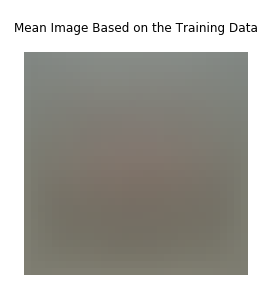

In [3]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
#print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.title('\nMean Image Based on the Training Data\n'); plt.axis('off')
plt.show()

In [4]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

Here we also append the bias vector of ones to the weight matrix (the usual bias trick) so that we optimize a single matrix of weights $W$. 

In [5]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Clasifier

We now write the multiclass support vector machine clasifyer (`SVM`). 

The final result is found here: [`./cs231n/classifiers/linear_svm.py`](./cs231n/classifiers/linear_svm.py).

> `./cs231n/classifiers/` is the relative path from the `assignment1` directory ( which is where all the downloaded assignment files were unzipped ) to the directory that contains files that implement classifiers. `linear_svm.py` is one of these classifiers that we modified to produce the results that follow.

## Implementing the Loss Function

We find the optimal set of $w$s by minimizing the hinge loss finction ( see the _Loss Function_ section of the [linear classification notes ](http://cs231n.github.io/linear-classify/) for details ). 

The *Loss Function* section of the [linear classification notes ](http://cs231n.github.io/linear-classify/) explains both the naive and the vectorized implementations of the hinge loss function.

The main work done here is the computation of gradients. 


In [6]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(10, 3073) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev.T, y_dev, 0.00001)
print 'loss: %f' % (loss, )

loss: 9.397138


## Computing the Gradients of the Loss Function

**So here we explain how gradient is implemented**

In [7]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev.T, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev.T, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

####
print '\Turning on regularization parameter...\n'
####


# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev.T, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev.T, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -40.223020 analytic: -40.223020, relative error: 6.607269e-12
numerical: 9.625019 analytic: 9.625019, relative error: 2.010647e-12
numerical: 17.827953 analytic: 17.827953, relative error: 3.539272e-12
numerical: 12.103922 analytic: 12.103922, relative error: 2.029601e-12
numerical: 8.578208 analytic: 8.578208, relative error: 3.850230e-11
numerical: -2.596941 analytic: -2.596941, relative error: 3.493883e-11
numerical: 9.048777 analytic: 9.048777, relative error: 3.521215e-11
numerical: -9.673788 analytic: -9.673788, relative error: 9.882464e-12
numerical: -3.692179 analytic: -3.692179, relative error: 1.224166e-10
numerical: 16.474268 analytic: 16.474268, relative error: 3.754507e-12
\Turning on regularization parameter...

numerical: -15.283101 analytic: -15.283101, relative error: 9.358153e-12
numerical: -7.597910 analytic: -7.597910, relative error: 1.189341e-11
numerical: -22.416496 analytic: -22.416496, relative error: 1.237376e-11
numerical: -9.156788 analytic: -9.15

#### This output verifies the analytically computed gradient agrees with the numerically computed one!

Next we do the vectorized implementation of the loss and the gradient.

We see a significant speed-up in computation time.

In [8]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev.T, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev.T, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 9.397138e+00 computed in 0.045009s
Vectorized loss: 9.397138e+00 computed in 0.005506s
difference: 0.000000


In [9]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev.T, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev.T, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.043286s
Vectorized loss and gradient: computed in 0.001956s
difference: 0.000000


## Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [10]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 786.180240
iteration 100 / 1500: loss 286.771810
iteration 200 / 1500: loss 107.338659
iteration 300 / 1500: loss 42.646295
iteration 400 / 1500: loss 18.812654
iteration 500 / 1500: loss 10.190641
iteration 600 / 1500: loss 7.682009
iteration 700 / 1500: loss 6.291302
iteration 800 / 1500: loss 5.383291
iteration 900 / 1500: loss 6.049773
iteration 1000 / 1500: loss 5.543185
iteration 1100 / 1500: loss 5.402423
iteration 1200 / 1500: loss 5.731897
iteration 1300 / 1500: loss 5.129143
iteration 1400 / 1500: loss 5.197602
That took 16.854939s


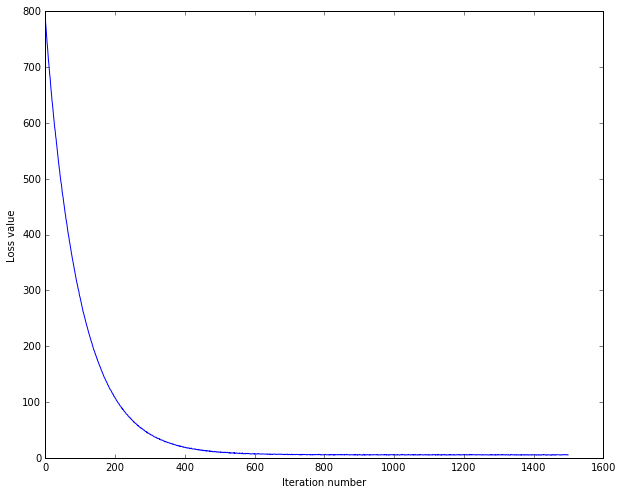

In [11]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.

### NOTE: RUNNING THIS TAKES A BIT OF TIME. UNCOMMENT THESE LINES TO DO THE SEARCH.
### WHAT FOLLOWS USES THE ALREADY TUNED HYPERPARAMETERS.

#learning_rates = [1e-7, 2e-7, 3e-7, 5e-5, 8e-7]
#regularization_strengths = [1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 1e5]

learning_rates = [1e-7]
regularization_strengths = [3e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
iters = 2000 #100
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=iters)
        
        y_train_pred = svm.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (acc_train, acc_val)
        
        if best_val < acc_val:
            best_val = acc_val
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

In [12]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.364367
validation accuracy: 0.378000


In [13]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.358000


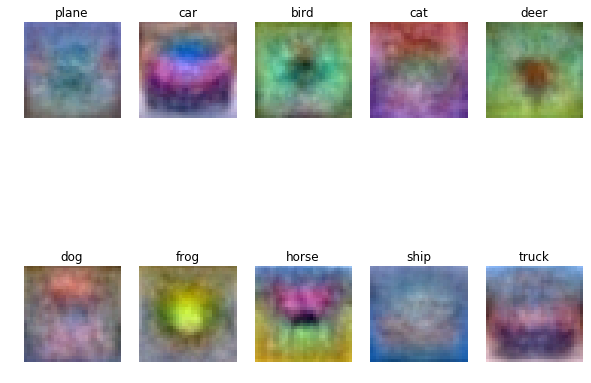

In [14]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

These do look like templates for the images, templates with quirks. For example, the two headed horse may be showing up as a template because the original images contain pictures of horses looking in both directions. The plane template is mostly blue, perhaps due to the blue sky background in most of the images. Similar explanation may work for the ship template. 